# Relevant Imports

In [110]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np

# Import libraries for text processing and modeling
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Import libraries for time series modeling
from statsmodels.tsa.api import VAR
from arch import arch_model


In [111]:
sentiment_MRK = pd.read_csv('../../dataset_final/Daily_Financial_News/MRK/MRK_text_annotated.csv')
sentiment_MS = pd.read_csv('../../dataset_final/Daily_Financial_News/MS/MS_text_annotated.csv')
sentiment_MU = pd.read_csv('../../dataset_final/Daily_Financial_News/MU/MU_text_annotated.csv')
sentiment_NVDA = pd.read_csv('../../dataset_final/Daily_Financial_News/NVDA/NVDA_text_annotated.csv')
sentiment_QQQ = pd.read_csv('../../dataset_final/Daily_Financial_News/QQQ/QQQ_text_annotated.csv')
# Add 'Stock' column to each sentiment DataFrame
sentiment_MRK['Stock'] = 'MRK'
sentiment_MS['Stock'] = 'MS'
sentiment_MU['Stock'] = 'MU'
sentiment_NVDA['Stock'] = 'NVDA'
sentiment_QQQ['Stock'] = 'QQQ'

# Combine all sentiment DataFrames
combined_sentiment = pd.concat([sentiment_MRK, sentiment_MS, sentiment_MU, sentiment_NVDA, sentiment_QQQ], ignore_index=True)

# Display the combined DataFrame
combined_sentiment.head()
combined_sentiment['Stock'].value_counts()  # Check distribution of stocks




Stock
MRK     3334
MS      3242
MU      3144
NVDA    3133
QQQ     3100
Name: count, dtype: int64

In [112]:
# Drop the 'Unnamed: 0' column
if 'Unnamed: 0' in combined_sentiment.columns:
    combined_sentiment= combined_sentiment.drop(columns=['Unnamed: 0'])
combined_sentiment = combined_sentiment.rename(columns={'Time': 'Date'})
combined_sentiment.head()

,title,stock,Date,sentiment_score,Stock
0,Shares of several healthcare companies are tra...,MRK,2020-06-11,-0.31,MRK
1,Johnson & Johnson To Start Coronavirus Vaccine...,MRK,2020-06-11,0.01,MRK
2,The Daily Biotech Pulse: Keytruda Setback For ...,MRK,2020-06-10,-0.38,MRK
3,Merck Announces That The Phase 3 KEYNOTE-361 T...,MRK,2020-06-09,0.00,MRK
4,"The Week Ahead In Biotech: Viela FDA Decision,...",MRK,2020-06-07,0.01,MRK


In [113]:
stock_MRK = pd.read_csv('../../dataset_final/Daily_Financial_News/MRK/MRK_numerical.csv')
stock_MS = pd.read_csv('../../dataset_final/Daily_Financial_News/MS/MS_numerical.csv')
stock_MU = pd.read_csv('../../dataset_final/Daily_Financial_News/MU/MU_numerical.csv')
stock_NVDA = pd.read_csv('../../dataset_final/Daily_Financial_News/NVDA/NVDA_numerical.csv')
stock_QQQ = pd.read_csv('../../dataset_final/Daily_Financial_News/QQQ/QQQ_numerical.csv')
# Add 'Stock' column to each sentiment DataFrame
stock_MRK['Stock'] = 'MRK'
stock_MS['Stock'] = 'MS'
stock_MU['Stock'] = 'MU'
stock_NVDA['Stock'] = 'NVDA'
stock_QQQ['Stock'] = 'QQQ'

# Combine all sentiment DataFrames
combined_stock = pd.concat([stock_MRK, stock_MS, stock_MU, stock_NVDA, stock_QQQ], ignore_index=True)

# Display the combined DataFrame
combined_stock.head()
combined_stock['Stock'].value_counts()  # Check distribution of stocks



Stock
MRK     2738
MS      2616
NVDA    2333
QQQ     2324
MU      2299
Name: count, dtype: int64

In [114]:
# Calculate aggregate sentiment scores (mean, sum, or median)
aggregate_sentiment = combined_sentiment.groupby('Date')['sentiment_score'].sum().reset_index()

# Rename the aggregated column for clarity
aggregate_sentiment.rename(columns={'sentiment_score': 'aggregate_sentiment_score'}, inplace=True)

# Check the result
print(aggregate_sentiment.head())


         Date  aggregate_sentiment_score
0  2009-07-27                       0.01
1  2009-08-07                       0.01
2  2009-08-10                       0.02
3  2009-08-17                       0.00
4  2009-09-18                       0.05


In [115]:
# Merge the aggregate sentiment scores with the original dataset
combined_sentiment = pd.merge(combined_sentiment, aggregate_sentiment, on='Date', how='left')

# Check the updated dataset
print(combined_sentiment.head())


                                               title stock        Date  \
0  Shares of several healthcare companies are tra...   MRK  2020-06-11   
1  Johnson & Johnson To Start Coronavirus Vaccine...   MRK  2020-06-11   
2  The Daily Biotech Pulse: Keytruda Setback For ...   MRK  2020-06-10   
3  Merck Announces That The Phase 3 KEYNOTE-361 T...   MRK  2020-06-09   
4  The Week Ahead In Biotech: Viela FDA Decision,...   MRK  2020-06-07   

   sentiment_score Stock  aggregate_sentiment_score  
0            -0.31   MRK                      -0.51  
1             0.01   MRK                      -0.51  
2            -0.38   MRK                      -0.36  
3             0.00   MRK                       1.02  
4             0.01   MRK                       0.01  


In [116]:
print("Stock Data Columns:", combined_stock.columns)
print("Sentiment Data Columns:", combined_sentiment.columns)


Stock Data Columns: Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Stock'], dtype='object')
Sentiment Data Columns: Index(['title', 'stock', 'Date', 'sentiment_score', 'Stock',
       'aggregate_sentiment_score'],
      dtype='object')


In [117]:
# Convert Date columns to datetime
combined_stock['Date'] = pd.to_datetime(combined_stock['Date'])
combined_sentiment['Date'] = pd.to_datetime(combined_sentiment['Date'])


In [118]:
# Perform an inner merge
merged_data = pd.merge(
    combined_stock, 
    combined_sentiment[['Date', 'aggregate_sentiment_score']],  # Select only required columns from sentiment_data
    on='Date',
    how='inner'
)

# Check the resulting dataframe
print(merged_data.head())


        Date   Open  Close   High     Volume Stock  aggregate_sentiment_score
0 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36
1 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36
2 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36
3 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36
4 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36


In [119]:
# Select the required columns
final_data = merged_data[['Date', 'Open', 'Close', 'High', 'Volume','Stock', 'aggregate_sentiment_score']]

# Check the final dataframe
print(final_data.head())


        Date   Open  Close   High     Volume Stock  aggregate_sentiment_score
0 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36
1 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36
2 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36
3 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36
4 2020-06-10  78.66  78.02  78.98  9080920.0   MRK                      -0.36


In [120]:
# Calculate daily returns
final_data['daily_return'] = (final_data['Close'] - final_data['Open']) / final_data['Open']

# Drop NaN values
final_data.dropna(subset=['aggregate_sentiment_score', 'daily_return'], inplace=True)


In [121]:
final_data.tail()

,Date,Open,Close,High,Volume,Stock,aggregate_sentiment_score,daily_return
73721,2011-03-16,55.02,54.15,55.34,176507700.0,QQQ,-0.13,-0.015812
73722,2011-03-16,55.02,54.15,55.34,176507700.0,QQQ,-0.13,-0.015812
73723,2011-03-16,55.02,54.15,55.34,176507700.0,QQQ,-0.13,-0.015812
73724,2011-03-16,55.02,54.15,55.34,176507700.0,QQQ,-0.13,-0.015812
73725,2011-03-16,55.02,54.15,55.34,176507700.0,QQQ,-0.13,-0.015812


In [122]:
# Remove duplicate rows
final_data = final_data.drop_duplicates()

# Check the dataframe after removing duplicates
print(final_data.head())
print(f"Number of rows after removing duplicates: {len(final_data)}")


         Date   Open  Close   High      Volume Stock  \
0  2020-06-10  78.66  78.02  78.98   9080920.0   MRK   
8  2020-06-09  79.37  78.49  79.68   8846168.0   MRK   
15 2020-06-08  77.43  79.10  79.38   9956838.0   MRK   
23 2020-06-05  78.34  78.49  79.32  10413347.0   MRK   
32 2020-06-04  77.54  77.81  78.39   9292930.0   MRK   

    aggregate_sentiment_score  daily_return  
0                       -0.36     -0.008136  
8                        1.02     -0.011087  
15                       0.35      0.021568  
23                       2.51      0.001915  
32                       0.56      0.003482  
Number of rows after removing duplicates: 11442


In [123]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on aggregate sentiment
result_sentiment = adfuller(final_data['aggregate_sentiment_score'])
print(f"Sentiment ADF Statistic: {result_sentiment[0]:.3f}")
print(f"Sentiment p-value: {result_sentiment[1]:.3e}")  # Use scientific notation for small p-values
print("Sentiment Stationary" if result_sentiment[1] < 0.05 else "Sentiment Non-Stationary")

# Perform ADF test on daily returns or volatility
result_other = adfuller(final_data['daily_return'])  # Replace 'daily_return' with 'volatility' if needed
print(f"Other ADF Statistic: {result_other[0]:.3f}")
print(f"Other p-value: {result_other[1]:.3e}")  # Use scientific notation for small p-values
print("Daily Return Stationary" if result_other[1] < 0.05 else "Daily Return Non-Stationary")


Sentiment ADF Statistic: -12.368
Sentiment p-value: 5.361e-23
Sentiment Stationary
Other ADF Statistic: -17.189
Other p-value: 6.571e-30
Daily Return Stationary


In [124]:
# Calculate correlation
correlation = final_data['aggregate_sentiment_score'].corr(final_data['daily_return'])
print(f"Correlation between aggregate sentiment and daily returns: {correlation:.3f}")


Correlation between aggregate sentiment and daily returns: 0.093


In [125]:
from statsmodels.tsa.stattools import grangercausalitytests
def print_granger_results(results, cause, effect):
    print(f"Testing if {cause} causes {effect}:\n")
    print(f"{'Lags':<10}{'F-statistic':<15}{'p-value':<15}{'Conclusion':<40}")
    print("-" * 60)
    for lag, res in results.items():
        f_stat = res[0]['ssr_ftest'][0]
        p_value = res[0]['ssr_ftest'][1]
        conclusion = "Significant causality" if p_value < 0.05 else "No significant causality"
        print(f"{lag:<10}{f_stat:<15.2f}{p_value:<15.4f}{conclusion:<40}")
    print("\n")

# Run Granger causality and print results
granger_results_sent_to_ret = grangercausalitytests(final_data[['aggregate_sentiment_score', 'daily_return']], maxlag=3, verbose=False)
granger_results_ret_to_sent = grangercausalitytests(final_data[['daily_return', 'aggregate_sentiment_score']], maxlag=3, verbose=False)

print_granger_results(granger_results_sent_to_ret, "sentiment", "daily returns")
print_granger_results(granger_results_ret_to_sent, "daily returns", "sentiment")


Testing if sentiment causes daily returns:

Lags      F-statistic    p-value        Conclusion                              
------------------------------------------------------------
1         12.13          0.0005         Significant causality                   
2         6.20           0.0020         Significant causality                   
3         6.86           0.0001         Significant causality                   


Testing if daily returns causes sentiment:

Lags      F-statistic    p-value        Conclusion                              
------------------------------------------------------------
1         7.29           0.0069         Significant causality                   
2         4.11           0.0165         Significant causality                   
3         4.11           0.0064         Significant causality                   




/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [126]:
from arch import arch_model

# Combine returns for all stocks
combined_returns = final_data.groupby('Date')['daily_return'].mean()*100

# Fit GARCH(1,1) model on combined returns
combined_garch = arch_model(combined_returns, vol='Garch', p=1, q=1)
combined_fit = combined_garch.fit(disp="off")

# Print results
print("Combined GARCH(1,1) Model Results")
print(combined_fit.summary())



Combined GARCH(1,1) Model Results
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3796.23
Distribution:                  Normal   AIC:                           7600.47
Method:            Maximum Likelihood   BIC:                           7623.71
                                        No. Observations:                 2467
Date:                Thu, Nov 21 2024   Df Residuals:                     2466
Time:                        22:41:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0303

In [127]:
# Add conditional volatility to the data
final_data['conditional_volatility'] = garch_fit.conditional_volatility


In [128]:
# Forecast volatility for the next 5 days
forecast = garch_fit.forecast(horizon=5)
forecasted_volatility = forecast.variance.iloc[-1].values

# Create a new DataFrame for the forecasted values
forecasted_data = pd.DataFrame({
    'Date': pd.date_range(start=final_data['Date'].iloc[-1], periods=6, freq='B')[1:],  # Future dates
    'forecasted_volatility': forecasted_volatility
})

# Append forecasted rows to the original dataset
final_data_with_forecasts = pd.concat([final_data, forecasted_data], ignore_index=True)



In [129]:
# Add lagged volatility features
for lag in range(1, 4):  # Example: Add 3 lags
    final_data[f'lagged_volatility_{lag}'] = final_data['conditional_volatility'].shift(lag)

# Drop rows with NaN values caused by lagging
final_data.dropna(inplace=True)


In [130]:
# Calculate shocks
residuals = garch_fit.resid
final_data['volatility_shocks'] = residuals**2 - garch_fit.conditional_volatility**2


In [131]:
final_data.tail()

,Date,Open,Close,High,Volume,Stock,aggregate_sentiment_score,daily_return,conditional_volatility,lagged_volatility_1,lagged_volatility_2,lagged_volatility_3,volatility_shocks
73705,2011-03-23,55.20,55.70,55.86,60365100.0,QQQ,0.06,0.009058,0.766176,0.725944,0.751891,0.702206,0.178463
73710,2011-03-22,55.58,55.40,55.61,36162100.0,QQQ,0.02,-0.003239,0.788049,0.766176,0.725944,0.751891,-0.495186
73714,2011-03-18,55.22,54.45,55.22,94887200.0,QQQ,0.02,-0.013944,0.767191,0.788049,0.766176,0.725944,1.442889
73718,2011-03-17,55.00,54.65,55.24,94434500.0,QQQ,-0.20,-0.006364,0.864448,0.767191,0.788049,0.766176,-0.302062
73720,2011-03-16,55.02,54.15,55.34,176507700.0,QQQ,-0.13,-0.015812,0.856666,0.864448,0.767191,0.788049,1.865048


In [132]:
from arch import arch_model

# Dictionary to store best models
best_models = {}

# Iterate over each stock in the data
for stock in final_data['Stock'].unique():
    stock_data = final_data[final_data['Stock'] == stock]
    stock_returns = stock_data['daily_return'] * 100  # Scaling returns to percentage

    # Initialize variables to track the best model
    best_aic = float('inf')
    best_model = None

    # Grid search over p and q values
    for p in range(1, 4):  # Example range for p (adjust as needed)
        for q in range(1, 4):  # Example range for q (adjust as needed)
            try:
                # Fit GARCH model
                model = arch_model(stock_returns, vol='Garch', p=p, q=q)
                fit = model.fit(disp="off")
                
                # Update best model if AIC is lower
                if fit.aic < best_aic:
                    best_aic = fit.aic
                    best_model = fit
            except Exception as e:
                print(f"Error for stock {stock}, p={p}, q={q}: {e}")
                continue

    # Save the best model for this stock
    best_models[stock] = best_model

# Print summaries of the best models
for stock, model in best_models.items():
    print(f"Best GARCH Model for {stock}:")
    print(model.summary())


Best GARCH Model for MRK:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3555.83
Distribution:                  Normal   AIC:                           7119.66
Method:            Maximum Likelihood   BIC:                           7142.89
                                        No. Observations:                 2464
Date:                Thu, Nov 21 2024   Df Residuals:                     2463
Time:                        22:41:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0199  1.991e

In [133]:
# Convert the Date column to datetime format
final_data['Date'] = pd.to_datetime(final_data['Date'])

# Ensure the GARCH models are aligned with the correct index
for stock, model in best_models.items():
    model.conditional_volatility.index = final_data[final_data['Stock'] == stock]['Date']
combined_fit.conditional_volatility.index = final_data['Date'].unique()  # Match unique dates for combined model


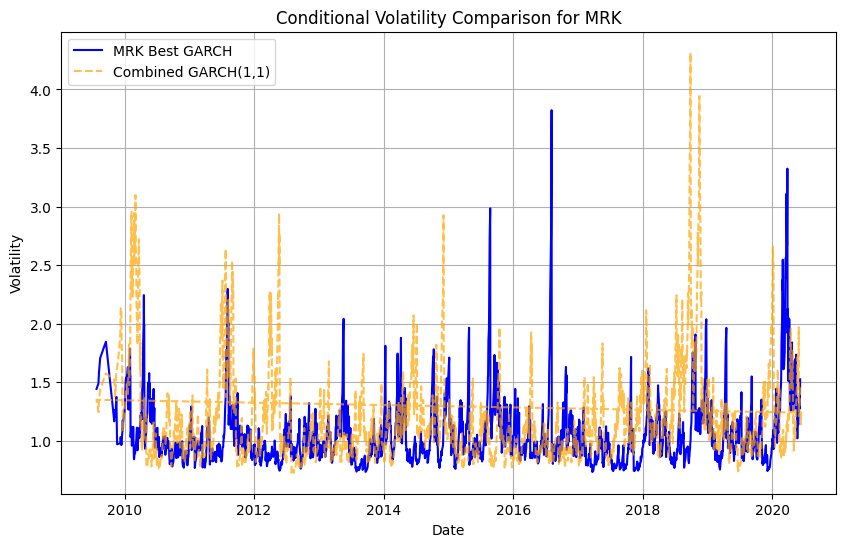

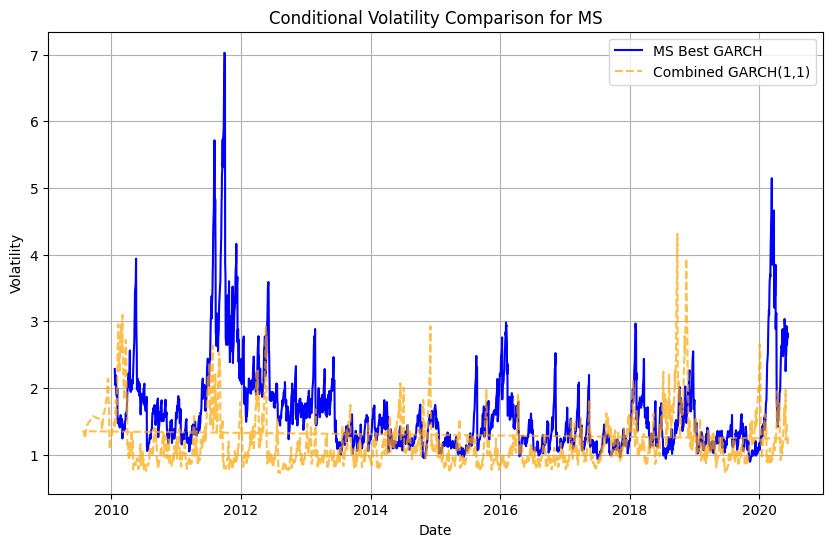

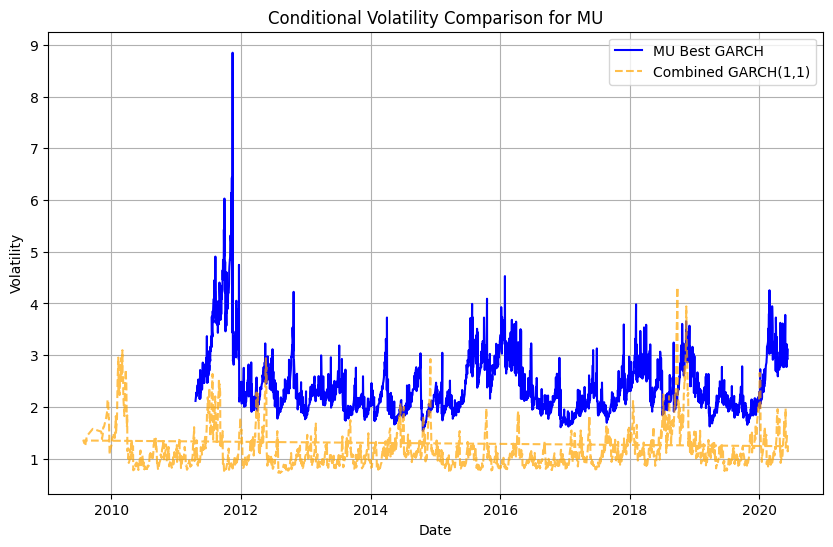

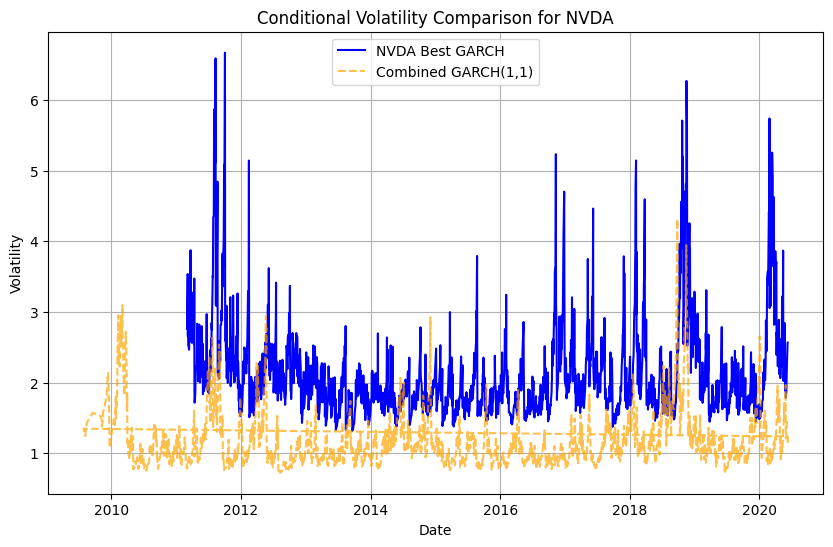

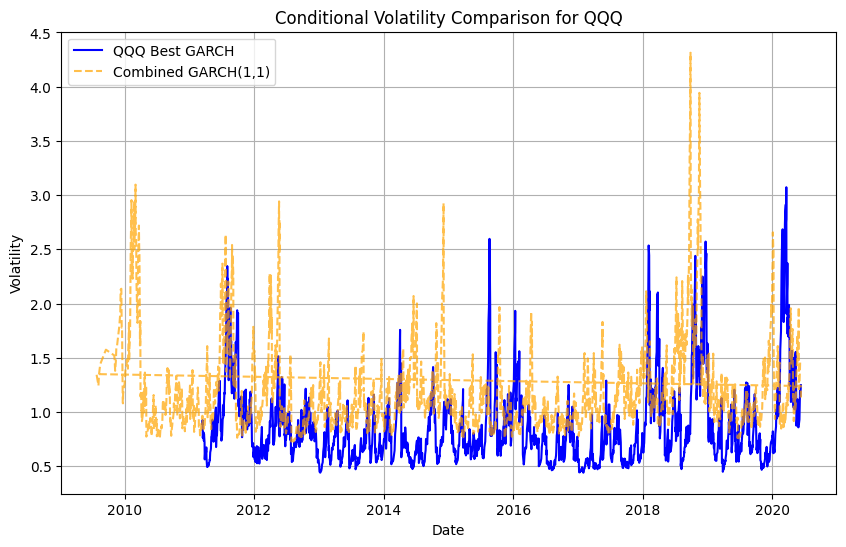

In [134]:
# Plot conditional volatility for each stock overlaid with the combined model
for stock, model in best_models.items():
    plt.figure(figsize=(10, 6))
    
    # Plot individual stock's best GARCH model
    plt.plot(model.conditional_volatility, label=f'{stock} Best GARCH', color='blue')
    
    # Plot combined GARCH model
    plt.plot(combined_fit.conditional_volatility, label='Combined GARCH(1,1)', color='orange', linestyle='dashed', alpha=0.7)
    
    # Add titles and labels
    plt.title(f'Conditional Volatility Comparison for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()
    plt.show()


In [135]:
import pandas as pd

# Collect metrics for combined model
comparison = [
    {
        'Model': 'Combined GARCH(1,1)',
        'AIC': combined_fit.aic,
        'Log-Likelihood': combined_fit.loglikelihood,
        'Stock': 'All'
    }
]

# Collect metrics for each stock's best model
for stock, model in best_models.items():
    comparison.append({
        'Model': f'{stock} Best GARCH',
        'AIC': model.aic,
        'Log-Likelihood': model.loglikelihood,
        'Stock': stock
    })

# Convert to DataFrame for visualization
comparison_df = pd.DataFrame(comparison)

# Display the table
print(comparison_df)


                 Model          AIC  Log-Likelihood Stock
0  Combined GARCH(1,1)  7600.469719    -3796.234859   All
1       MRK Best GARCH  7119.656206    -3555.828103   MRK
2        MS Best GARCH  9001.963659    -4496.981829    MS
3        MU Best GARCH  9842.924973    -4915.462486    MU
4      NVDA Best GARCH  9360.530292    -4674.265146  NVDA
5       QQQ Best GARCH  5260.737397    -2626.368698   QQQ


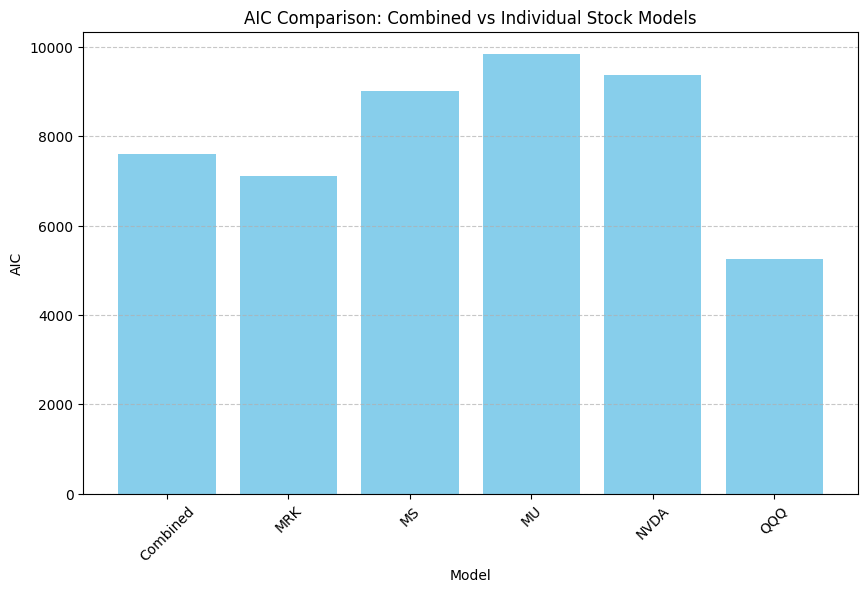

In [137]:
import matplotlib.pyplot as plt

# Data for plotting
stocks = ['Combined', 'MRK', 'MS', 'MU', 'NVDA', 'QQQ']
aic_values = [7600.47, 7119.66, 9001.96, 9842.92, 9360.53, 5260.73]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(stocks, aic_values, color='skyblue')
plt.title('AIC Comparison: Combined vs Individual Stock Models')
plt.ylabel('AIC')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('AIC_Comparison.png')
plt.show()
